# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit 


# Useful Data

## Doppler-Broadened Lines

In [3]:
# Frequency differences in MHZ between the 87 and 85 transitions, for the GS
f_87D2 = 384230484
f_85D2 = 384230406
f_87F1_rel = +4272
f_87F2_rel = -2563
f_85F2_rel = +1771
f_85F3_rel = -1265
df_87_F1 = f_87D2 + f_87F1_rel
df_87_F2 = f_87D2 + f_87F2_rel
df_85_F2 = f_85D2 + f_85F2_rel
df_85_F3 = f_85D2 + f_85F3_rel

# laser frequency, putting the zero to the resonance with 87_F1
fL_87_F1 = df_87_F1 - df_87_F1
fL_87_F2 = df_87_F2 - df_87_F1
fL_85_F2 = df_85_F2 - df_87_F1
fL_85_F3 = df_85_F3 - df_87_F1

# array of the relative laser frequencies from the smallest to the largest
fl_array = np.array([fL_87_F1,fL_85_F2,fL_85_F3,fL_87_F2])

# Useful Functions

## Fitting Functions

In [4]:
# Gaussian functions for the fitting of the doppler-broadened lines
def Gauss(x, A, D,x0): 
    y = A*np.exp(-(x-x0)**2/(2*D**2)) 
    return y 

# Lorentzian function with amplitude A, width D, and center x0
def Lor(x,x0,D,A):
    return A/(1+(x-x0)**2/D**2)

# Fitting function for 6 SAS peaks, with a gaussian envelope
def SAS_fit_6(x,x1,D1,A1,x2,D2,A2,x3,D3,A3,x4,D4,A4,x5,D5,A5,x6,D6,A6,x0G,DG):
    'x is the independent variable, x0G, DG are the center and width of the Gaussian envelope, the rest are the parameters for the 6 Lorentzian peaks.'
    v = 0
    v += Lor(x,x1,D1,A1)
    v += Lor(x,x2,D2,A2)
    v += Lor(x,x3,D3,A3)
    v += Lor(x,x4,D4,A4)
    v += Lor(x,x5,D5,A5)
    v += Lor(x,x6,D6,A6)
    v *= np.exp(-(x-x0G)**2/(2*DG**2))
    return v

def get_centers_6(params):
    'returns the centers of the 6 peaks'
    return np.array([params[0],params[3],params[6],params[9],params[12],params[15]])

def get_widths_6(params):
    'returns the widths of the 6 peaks'
    return np.array([params[1],params[4],params[7],params[10],params[13],params[16]])

## Data Analysis Function

In [5]:
# this function finds where the voltage ramp of the function generator starts and ends averaging out the signal and finding the max 

def find_extremes_ramp(x):
    t = np.arange(0,len(x))
    step = 5 # take the average every 5 points
    width = 25 # width of the averaging window
    l_d = int((len(x)-width)/step)+1
    pos_arr = np.zeros(l_d)
    avg_arr = np.zeros(l_d)
    for i in range(l_d):
        pos_arr[i] = i*step + width/2
        avg_arr[i] = np.mean(x[i*step:i*step+width])
    start = pos_arr[np.argmin(avg_arr)]
    end = pos_arr[np.argmax(avg_arr)]
    # if the start is after the end, swap them
    if start > end:
        start,end = end,start
    return int(start),int(end)

# this function identifies the regions where the spectroscopy signal is linear (ie far from the resonances) with the second derivative of the signal

def find_where_linear(x, ax):
    t = np.arange(0,len(x))
    step = 10  # take the average every 10 points
    width = 40 # width of the fitting window
    l_dd = int((len(x)-width)/step)+1
    dd_arr = np.zeros(l_dd)
    pos_arr = np.zeros(l_dd)
    for i in range(l_dd):
        pfit = np.polyfit(t[i*step:i*step+width],x[i*step:i*step+width],2) # fit a second order polynomial
        dd_arr[i] = pfit[0] # the second derivative is the first coefficient of the polynomial
        pos_arr[i] = i*step + width/2
    lim = np.amax(abs(dd_arr))/15 # IMPORTANT threshold for the second derivative to be basically considered 0, can be adjusted if needed

    # plot the second derivative and the threshold, useful for adjusting the threshold
    ax.plot(pos_arr,abs(dd_arr))
    ax.axhline(y=lim, color='r', linestyle='-')
    ax.set_title('Second derivative, linear finding')
    
    # take the regions where the second derivative is below the threshold for at least a fixed number of points (avoiding noise)
    thr_points = 5 # IMPORTANT minimum number of points below the threshold, can be adjusted if needed
    dd_arr = abs(dd_arr)
    dd_arr[dd_arr<lim] = 0
    starts = np.zeros(4)
    ends = np.zeros(4)
    idx = 0
    running = False
    for i in range(len(dd_arr)-1):
        if (dd_arr[i] == 0) and (running == False):
            starts[idx] = pos_arr[i]
            running = True
            cnt = 1
        if (dd_arr[i] == 0) and (running == True):
            cnt += 1
        if (dd_arr[i] != 0) and (running == True):
            if cnt > thr_points:
                ends[idx] = pos_arr[i]
                idx += 1
                running = False
            if cnt<thr_points:
                running = False
    ends[-1] = pos_arr[-1]
    return starts,ends



## Miscellaneous Functions

In [6]:
# takes a file with the data in columns of t,signal,FG and saves in arrays

def read_file(filename):
    data = np.loadtxt(filename,skiprows=2,delimiter=",",dtype=str)
    t = data[:,0].astype(float)
    V_pd = data[:,1].astype(float)
    V_fg = data[:,2].astype(float)
    return t,V_pd,V_fg

# Hyperfine Analysis of Rb87, Fg=2 Line

## Frequency Values

Here I save all the frequency values of the hyperfine states found in this line. The frequencies are relative to the center of the p-line

In [7]:
# we save all frequencies from the p line center

f_Rb87_Fe0 = - 302.074
f_Rb87_Fe1 = - 229.852
f_Rb87_Fe2 = - 72.911
f_Rb87_Fe3 = + 193.741
f_Rb87_CO_01 = (f_Rb87_Fe0 + f_Rb87_Fe1)/2
f_Rb87_CO_12 = (f_Rb87_Fe1 + f_Rb87_Fe2)/2
f_Rb87_CO_23 = (f_Rb87_Fe2 + f_Rb87_Fe3)/2
f_Rb87_CO_13 = (f_Rb87_Fe0 + f_Rb87_Fe3)/2
f_Rb87_CO_02 = (f_Rb87_Fe0 + f_Rb87_Fe2)/2
f_Rb87_CO_03 = (f_Rb87_Fe1 + f_Rb87_Fe3)/2

## Post-Processing the data

I take the Doppler-broadened and Doppler-free data in AC and DC and process them to obtain the cleanest possible data

Text(0, 0.5, 'Voltage (V)')

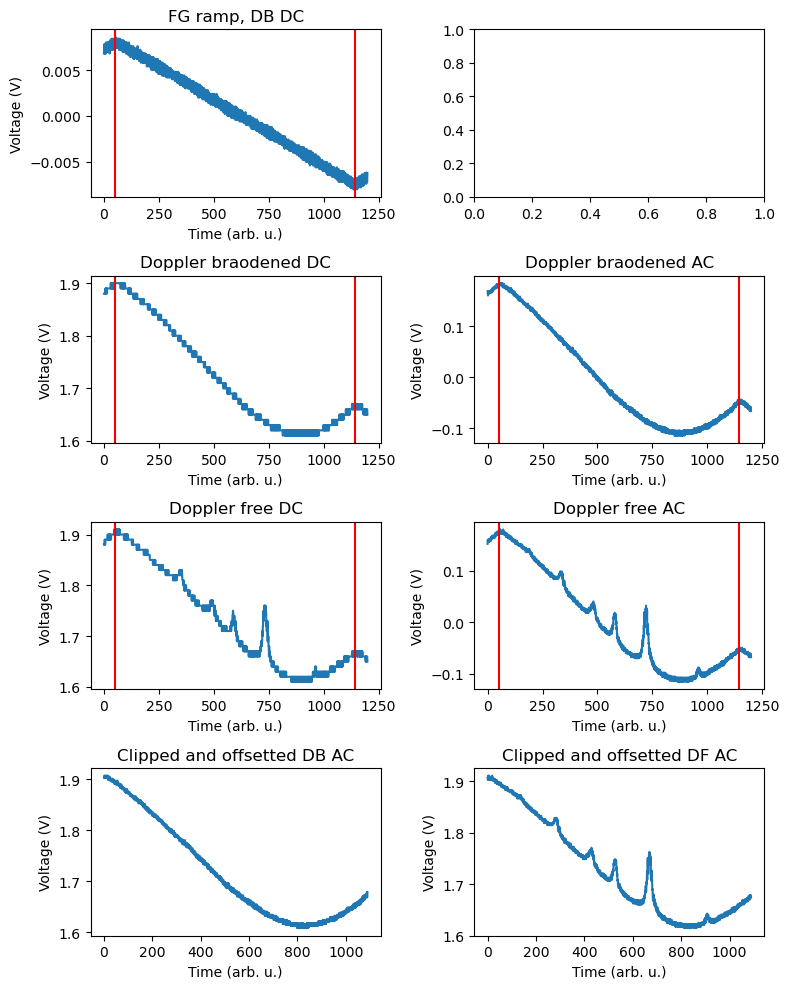

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10), tight_layout=True)

# get the four files with the data
t_DB_DC,V_pd_DB_DC,V_fg_DB_DC = read_file("/media/jacklook/JL_USB/NewFile20.csv")
t_DB_AC, V_pd_DB_AC, V_fg_DB_AC = read_file("/media/jacklook/JL_USB/NewFile21.csv")
t_DF_DC, V_pd_DF_DC, V_fg_DF_DC = read_file("/media/jacklook/JL_USB/NewFile19.csv")
t_DF_AC, V_pd_DF_AC, V_fg_DF_AC = read_file("/media/jacklook/JL_USB/NewFile18.csv")

# I now find the extremes of the voltage ramp for the function generator
start,end = find_extremes_ramp(V_fg_DB_DC)
ax[0,0].plot(V_fg_DB_DC)
ax[0,0].set_title("FG ramp, DB DC")
ax[0,0].axvline(x=start, color='r', linestyle='-')
ax[0,0].axvline(x=end, color='r', linestyle='-')
ax[0,0].set_xlabel("Time (arb. u.)")
ax[0,0].set_ylabel("Voltage (V)")

# I now take the AC data, correct the DC offset and clip them
V_pd_DB_AC_c = V_pd_DB_AC - np.mean(V_pd_DB_AC) + np.mean(V_pd_DB_DC)
V_pd_DB_AC_c = V_pd_DB_AC_c[start:end]
V_pd_DF_AC_c = V_pd_DF_AC - np.mean(V_pd_DF_AC) + np.mean(V_pd_DF_DC)
V_pd_DF_AC_c = V_pd_DF_AC_c[start:end]

# plot everything to see the files are correct

ax[1,0].plot(t_DB_DC,V_pd_DB_DC)
ax[1,0].axvline(x=start, color='r', linestyle='-')
ax[1,0].axvline(x=end, color='r', linestyle='-')
ax[1,0].set_title("Doppler braodened DC")
ax[1,1].plot(t_DB_AC,V_pd_DB_AC)
ax[1,1].axvline(x=start, color='r', linestyle='-')
ax[1,1].axvline(x=end, color='r', linestyle='-')
ax[1,1].set_title("Doppler braodened AC")
ax[2,0].plot(t_DF_DC,V_pd_DF_DC)
ax[2,0].axvline(x=start, color='r', linestyle='-')
ax[2,0].axvline(x=end, color='r', linestyle='-')
ax[2,0].set_title("Doppler free DC")
ax[2,1].plot(t_DF_AC,V_pd_DF_AC)
ax[2,1].axvline(x=start, color='r', linestyle='-')
ax[2,1].axvline(x=end, color='r', linestyle='-')
ax[2,1].set_title("Doppler free AC")

ax[3,0].plot(V_pd_DB_AC_c)
ax[3,0].set_title("Clipped and offsetted DB AC")
ax[3,1].plot(V_pd_DF_AC_c)
ax[3,1].set_title("Clipped and offsetted DF AC")

ax[1,0].set_xlabel("Time (arb. u.)")
ax[1,0].set_ylabel("Voltage (V)")
ax[1,1].set_xlabel("Time (arb. u.)")
ax[1,1].set_ylabel("Voltage (V)")
ax[2,0].set_xlabel("Time (arb. u.)")
ax[2,0].set_ylabel("Voltage (V)")
ax[2,1].set_xlabel("Time (arb. u.)")
ax[2,1].set_ylabel("Voltage (V)")
ax[3,0].set_xlabel("Time (arb. u.)")
ax[3,0].set_ylabel("Voltage (V)")
ax[3,1].set_xlabel("Time (arb. u.)")
ax[3,1].set_ylabel("Voltage (V)")



## Fitting

I now compute the Doppler-free absorption profile and fit it, I then fit the centers of the Lorentzian with the true frequencies

Widths:  [28.45958868  6.1062959   7.36637206  5.06193008  6.39115573  2.96641457]


Text(0, 0.5, 'Time (arb. u.)')

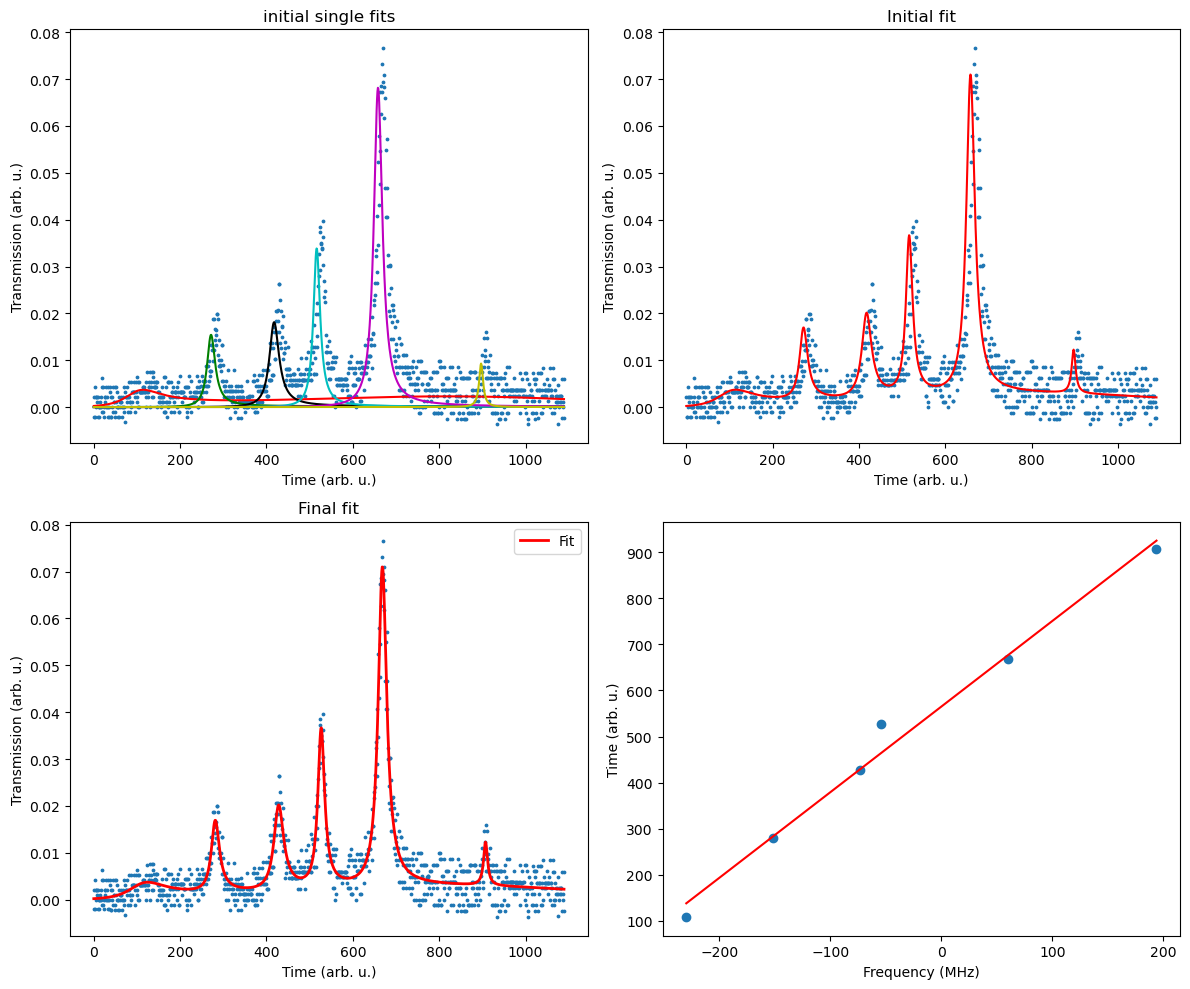

In [13]:
fig,ax = plt.subplots(2,2,figsize=(12,10),tight_layout=True)

# I now compute the absorption signal
K_sg = np.log(V_pd_DF_AC_c/V_pd_DB_AC_c)
x = np.arange(len(K_sg))


# array of six colours
colors = ['r','g','k','c','m','y']

lor_1 = np.array([99,51.23,0.639])
lor_2 = np.array([271,11.35,0.529])
lor_3 = np.array([417,13.6,0.191])
lor_4 = np.array([516,9.39,0.184])
lor_5 = np.array([658,11.87,0.173])
lor_6 = np.array([897,5.54,0.0109])
lor_s = np.array([lor_1,lor_2,lor_3,lor_4,lor_5,lor_6])
gauss = np.array([1066,298.9,0.01])

ax[0,0].scatter(x,K_sg,s=3)
for i in range(6):
    #ax[0,0].axhline(y=lor_s[i,2]*np.exp(-(lor_s[i,0]-gauss[0])**2/2/gauss[1]**2), color=colors[i], linestyle='-')
    #ax[0,0].axvline(x=lor_s[i,0], color=colors[i], linestyle='-')
    #ax[0,0].axvspan(lor_s[i,0]-lor_s[i,1],lor_s[i,0]+lor_s[i,1], alpha=0.2, color=colors[i])
    ax[0,0].plot(x,Lor(x,lor_s[i,0],lor_s[i,1],lor_s[i,2])*np.exp(-(x-gauss[0])**2/2/gauss[1]**2),color=colors[i])

ax[0,0].set_title("initial single fits")
ax[0,0].set_xlabel("Time (arb. u.)")
ax[0,0].set_ylabel("Transmission (arb. u.)")

p0 = [lor_1[0],lor_1[1],lor_1[2],lor_2[0],lor_2[1],lor_2[2],lor_3[0],lor_3[1],lor_3[2],lor_4[0],lor_4[1],lor_4[2],lor_5[0],lor_5[1],lor_5[2],lor_6[0],lor_6[1],lor_6[2],gauss[0],gauss[1]]

# get the fit with the initial parameters
fit_0 = SAS_fit_6(x,*p0)

ax[0,1].scatter(x,K_sg,s=3)
ax[0,1].plot(x,fit_0,color='r',label='Initial fit')
ax[0,1].set_title("Initial fit")
ax[0,1].set_xlabel("Time (arb. u.)")
ax[0,1].set_ylabel("Transmission (arb. u.)")

popt, pcov = curve_fit(SAS_fit_6, x, K_sg, p0)
ax[1,0].scatter(x,K_sg,s=3)
ax[1,0].plot(x,SAS_fit_6(x,*popt),lw=2,c='r',label='Fit')
ax[1,0].set_title("Final fit")
ax[1,0].set_xlabel("Time (arb. u.)")
ax[1,0].set_ylabel("Transmission (arb. u.)")
ax[1,0].legend()

fs = np.array([f_Rb87_Fe1,f_Rb87_CO_12,f_Rb87_Fe2,f_Rb87_CO_13,f_Rb87_CO_23,f_Rb87_Fe3])
centers = get_centers_6(popt)
ind = np.argsort(centers)
centers = centers[ind]
lin = np.polyfit(fs,centers,1)
ax[1,1].scatter(fs,centers)
ax[1,1].plot(fs,lin[0]*fs+lin[1],c='r',label='Linear fit')
print("Widths: ",get_widths_6(popt)[ind]/lin[0])
ax[1,1].set_xlabel("Frequency (MHz)")
ax[1,1].set_ylabel("Time (arb. u.)")



# Doppler-broadened spectroscopy

Here I do all the analysis for the Doppler-broadened data, as explained in "Theory_Spectroscopy.pdf"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Relative Frequency (MHz)')

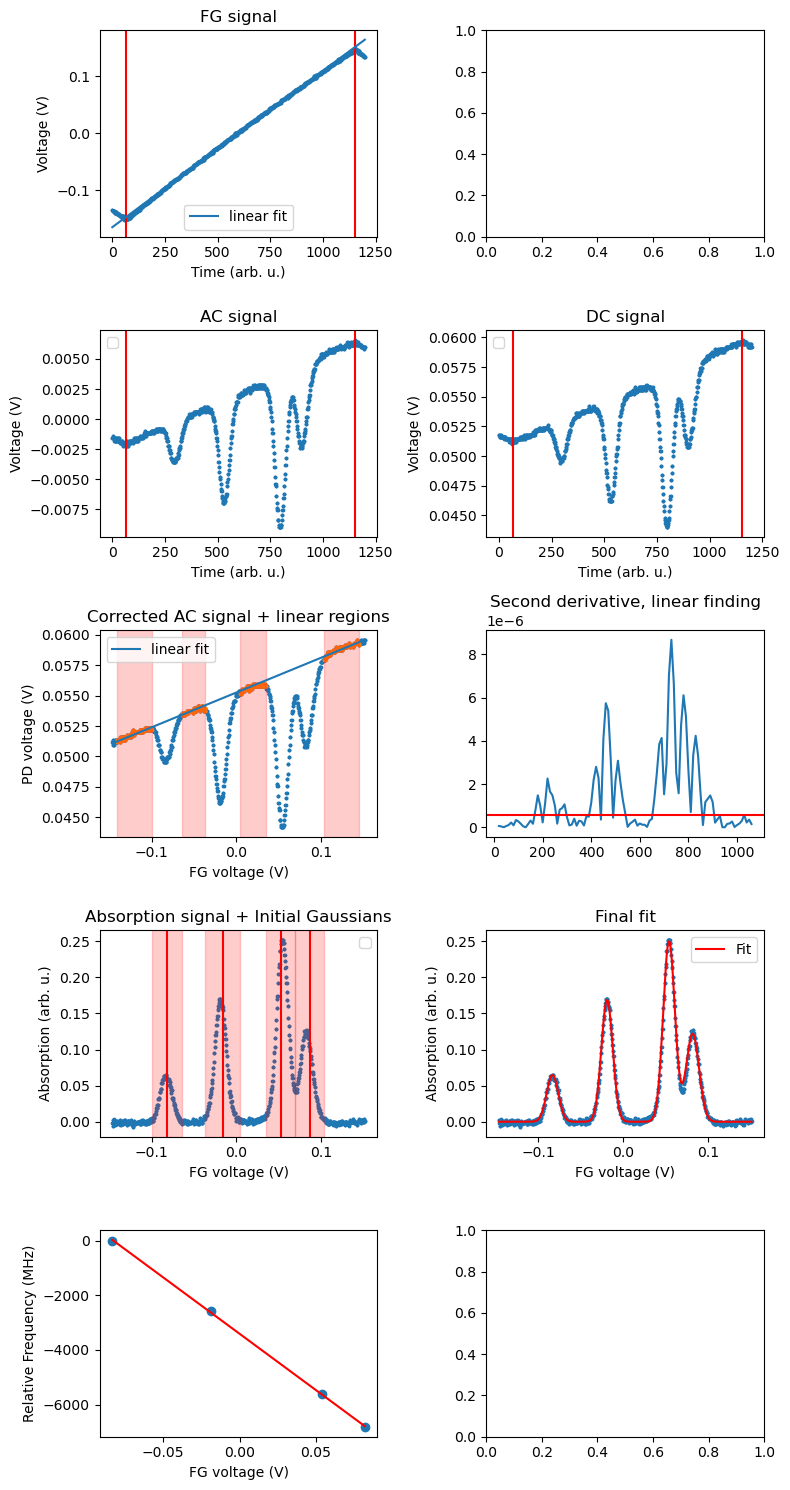

In [21]:
fig,ax = plt.subplots(5,2,figsize=(8,15),tight_layout=True)

# load the data
t_DC,V_fg_DC,V_pd_DC = read_file("/media/jacklook/JL_USB/NewFile13.csv")
t_AC,V_fg_AC,V_pd_AC = read_file("/media/jacklook/JL_USB/NewFile12.csv")

# find the extremes of the voltage ramp
start,end = find_extremes_ramp(V_fg_DC)

# linearize the FG signal
Vf_vs_t_linfit = np.polyfit(t_DC[start:end],V_fg_DC[start:end],1)
Vf_vs_t_a = Vf_vs_t_linfit[0]
Vf_vs_t_b = Vf_vs_t_linfit[1]
Vf_better = Vf_vs_t_a*t_DC+Vf_vs_t_b

ax[0,0].scatter(t_DC,V_fg_DC,s=3)
ax[0,0].axvline(x=start, color='r', linestyle='-')
ax[0,0].axvline(x=end, color='r', linestyle='-')
ax[0,0].plot(t_DC,t_DC*Vf_vs_t_a+Vf_vs_t_b,label='linear fit')
ax[0,0].set_title("FG signal")
ax[0,0].set_xlabel("Time (arb. u.)")
ax[0,0].set_ylabel("Voltage (V)")
ax[0,0].legend()

ax[1,0].scatter(t_AC,V_pd_AC,s=3)
ax[1,0].axvline(x=start, color='r', linestyle='-')
ax[1,0].axvline(x=end, color='r', linestyle='-')
ax[1,0].set_title("AC signal")
ax[1,0].set_xlabel("Time (arb. u.)")
ax[1,0].set_ylabel("Voltage (V)")
ax[1,0].legend()

ax[1,1].scatter(t_DC,V_pd_DC,s=3)
ax[1,1].axvline(x=start, color='r', linestyle='-')
ax[1,1].axvline(x=end, color='r', linestyle='-')
ax[1,1].set_title("DC signal")
ax[1,1].set_xlabel("Time (arb. u.)")
ax[1,1].set_ylabel("Voltage (V)")
ax[1,1].legend()

# correct the Vfg vs t for clipping
Vf_vs_t_b = Vf_vs_t_a*start+Vf_vs_t_b

# correct the AC signal for the DC offset and clip it
V_pd_AC_c = V_pd_AC - np.mean(V_pd_AC) + np.mean(V_pd_DC)
V_pd_AC_c = V_pd_AC_c[start:end]
Vf_c = Vf_better[start:end]

# find where the signal is linear
starts,ends = find_where_linear(V_pd_AC_c,ax[2,1])

# collect the indexes of the linear regions
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)

# fit the linear part of the signal, to find the relation Vfg vs Vpd out of resonance
Vf_lin = Vf_c[lin_indexes]
Vpd_lin = V_pd_AC_c[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]

# transform regions from t to Vf
starts = starts*Vf_vs_t_a+Vf_vs_t_b
ends = ends*Vf_vs_t_a+Vf_vs_t_b

ax[2,0].scatter(Vf_c,V_pd_AC_c,s=3)
ax[2,0].scatter(Vf_lin,Vpd_lin,s=3)
ax[2,0].plot(Vf_c,Vf_c*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
for i in range(4):
    ax[2,0].axvspan(starts[i],ends[i], alpha=0.2, color='r')
ax[2,0].set_title("Corrected AC signal + linear regions")
ax[2,0].set_xlabel("FG voltage (V)")
ax[2,0].set_ylabel("PD voltage (V)")
ax[2,0].legend()

# compute the absorption signal
K_sg = -np.log(V_pd_AC_c/(Vf_c*Vpd_vs_Vf_a+Vpd_vs_Vf_b))

# fit the absorption signal
G_s1 = ends[0]
G_e1 = starts[1]
G_s2 = ends[1]
G_e2 = starts[2]
G_s3 = ends[2]
G_e3 = 0.5*ends[2]+0.5*starts[3]
G_s4 = 0.5*ends[2]+0.5*starts[3]
G_e4 = starts[3]

G_s = np.array([G_s1,G_s2,G_s3,G_s4])
Gs_ind = (G_s-Vf_vs_t_b)/Vf_vs_t_a
G_e = np.array([G_e1,G_e2,G_e3,G_e4])
Ge_ind = (G_e-Vf_vs_t_b)/Vf_vs_t_a
G_c = (G_e+G_s)/2
G_d = np.zeros(4)


ax[3,0].scatter(Vf_c,K_sg,s=3)

for i in range(4):
    ax[3,0].axvspan(G_s[i],G_e[i], alpha=0.2, color='r')
    ax[3,0].axvline(x=G_c[i], color='r', linestyle='-')

ax[3,0].set_title("Absorption signal + Initial Gaussians")
ax[3,0].set_xlabel("FG voltage (V)")
ax[3,0].set_ylabel("Absorption (arb. u.)")
ax[3,0].legend()

# now fit absorption signal
gauss_tot = np.zeros(len(Vf_c))
for i in range(4):
    popt,pcov = curve_fit(Gauss,Vf_c[int(Gs_ind[i]):int(Ge_ind[i])],K_sg[int(Gs_ind[i]):int(Ge_ind[i])],p0=[0.1,0.1,G_c[i]])
    gauss_tot += Gauss(Vf_c,*popt)
    G_c[i] = popt[2]
    G_d[i] = popt[1]

ax[3,1].plot(Vf_c,gauss_tot,c='r',label='Fit')
ax[3,1].scatter(Vf_c,K_sg,s=3)
ax[3,1].set_title("Final fit")
ax[3,1].set_xlabel("FG voltage (V)")
ax[3,1].set_ylabel("Absorption (arb. u.)")
ax[3,1].legend()

# now fit frequency vs center
Vf_vs_fl_linfit = np.polyfit(G_c,fl_array,1)
Vf_vs_fl_a = Vf_vs_fl_linfit[0]
Vf_vs_fl_b = Vf_vs_fl_linfit[1]

ax[4,0].scatter(G_c,fl_array)
ax[4,0].plot(G_c,Vf_vs_fl_a*G_c+Vf_vs_fl_b,c='r',label='Fit')
ax[4,0].set_xlabel("FG voltage (V)")
ax[4,0].set_ylabel("Relative Frequency (MHz)")

Text(0.5, 1.0, 'Rescaled absorption signal')

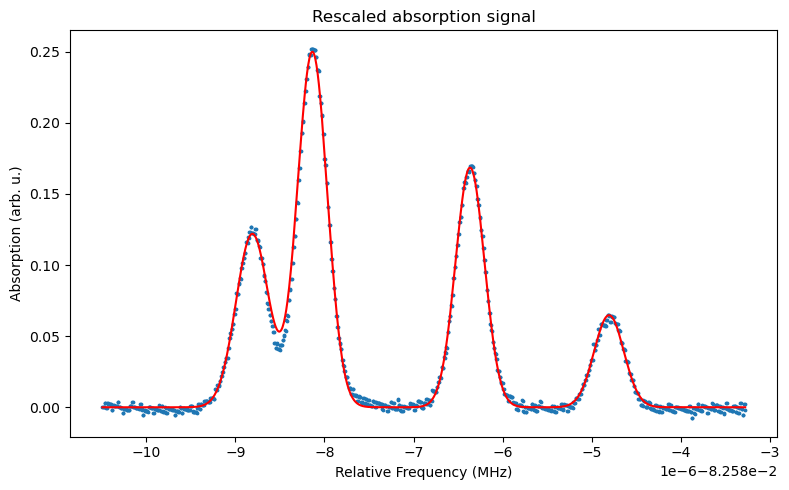

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,5),tight_layout=True)

# now rescale absorption signal
fl_vals = (Vf_c-Vf_vs_fl_b)/Vf_vs_fl_a

ax.plot(fl_vals,gauss_tot,c='r',label='Fit')
ax.scatter(fl_vals,K_sg,s=3)
ax.set_xlabel("Relative Frequency (MHz)")
ax.set_ylabel("Absorption (arb. u.)")
ax.set_title("Rescaled absorption signal")